Approach: ELECTRA (fine tuning)

In [1]:
model_name = "bhadresh-savani/electra-base-discriminator-finetuned-conll03-english"

### Install dependencies

In [2]:
!pip install tokenizers -q
!pip install transformers -q
!pip install transformers[torch] -q
!pip install seqeval -q  
!pip install evaluate -q

In [3]:
import spacy
import numpy as np
import pandas as pd
import json
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from transformers import AutoTokenizer, ElectraTokenizerFast, TrainingArguments, Trainer, DataCollatorForTokenClassification, TrainerCallback
from datasets import DatasetDict, Dataset, load_metric, load_from_disk
import traceback
from tqdm import tqdm
from evaluate import load
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForTokenClassification, ElectraForTokenClassification, AdamW
# from google.colab import drive
import warnings
import pickle

In [4]:
class EmptyCacheCallback(TrainerCallback):
    def on_train_batch_end(self, args, state, control, *_) -> None:
        torch.cuda.empty_cache()

# Instantiate the EmptyCacheCallback
empty_cache_callback = EmptyCacheCallback()

In [5]:
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/256_Project
PATH = '/home/rsangal/private/256_Project'
MODEL_PATH = PATH + '/electra-fine-tune'

### Load dataset (skip when needed)

In [ ]:
with open('data/NER_TRAIN_JUDGEMENT.json', 'r') as f:
    train_judge = json.load(f)

with open('data/NER_TRAIN_PREAMBLE.json', 'r') as f:
    train_preamble = json.load(f)
    
with open('data/NER_DEV_JUDGEMENT.json', 'r') as f:
    test_judge = json.load(f)
    
with open('data/NER_DEV_PREAMBLE.json', 'r') as f:
    test_preamble = json.load(f)

In [ ]:
len(train_judge), len(train_preamble), len(test_judge), len(test_preamble)

In [ ]:
test_judge[0]

In [ ]:
# test_preamble[0]

### Initializing tokenizer & Label Encoder

In [6]:
ner_labels = ['NO_TAG', 'COURT', 'PETITIONER', 'RESPONDENT', 'JUDGE', 'LAWYER', 'DATE', 'ORG', 'GPE', 'STATUTE',
              'PROVISION', 'PRECEDENT', 'CASE_NUMBER', 'WITNESS', 'OTHER_PERSON']

label_encoder = LabelEncoder()
label_encoder.fit(ner_labels)

encoded_labels = label_encoder.transform(ner_labels)
print(label_encoder.inverse_transform([6])[0])
# label_encoder.transform(['NO_TAG'])[0]

print(encoded_labels)
print(type(encoded_labels))

NO_TAG
[ 6  1  9 12  4  5  2  7  3 13 11 10  0 14  8]
<class 'numpy.ndarray'>


In [7]:
# tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base", is_split_into_words=True)
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", is_split_into_words=True)

tokenizer = ElectraTokenizerFast.from_pretrained(model_name)


In [ ]:
# Test Example
# text = "Hello, World eating"
# text = "True, our Constitution has no 'due process' clause or the VIII Amendment; but, \
# in this branch of law, after R.C. Cooper v. Union of India, (1970) 1 SCC 248 and Maneka Gandhi v.\
# Union of India, (1978) 1 SCC 248, the consequence is the same."
# tokenized_output = tokenizer(text, truncation=True, padding=True, return_offsets_mapping=True, return_tensors="pt")
# tokens = tokenizer.convert_ids_to_tokens(tokenized_output["input_ids"][0])

# print(tokens)
# print(len(tokens))
# print(tokenized_output)
# print(tokenized_output.input_ids)
# print(type(tokenized_output))
# print(tokenized_output.word_ids())



### Data Preprocessing (skip when needed)

Start, end in dataset is 1 indexed <br/>
start - starts from 1 <br/>
end - 1 character after the word

In [ ]:
def get_token_start(start, end, offsets_mapping, word_ids):
    token_start = None
    for i, interval in enumerate(offsets_mapping):
        left, right = interval
        if left<=start<right:
            token_start = i
            break
            
        if left>start:
            token_start = i
            break
    
    if token_start>0:
        if word_ids[token_start-1]==word_ids[token_start]:
            token_start -=1
        
    return token_start

def get_token_end(start, end, offsets_mapping, word_ids):
    token_end = None
    for i, interval in enumerate(offsets_mapping):
        left, right = interval
        if left<end<=right:
            token_end = i
            break
            
        if left>=end:
            token_end = i
            break
    
    if token_end<len(word_ids)-1:
        if word_ids[token_end+1]==word_ids[token_end]:
            token_end +=1
        
    return token_end

In [ ]:
def process_individual_record(rec):
    
    text = rec['data']['text']
    text = text.replace("),", ") ,").replace(").", ") .").replace("],", "] ,").replace("].", "] .")
    annotations = rec['annotations'][0]['result']

    # Get the start and end positions of annotated tokens
    annotated_token_positions = [(ann['value']['start'], ann['value']['end']) for ann in annotations]

    tokenized_inputs = tokenizer(text, padding="max_length", max_length=120, truncation= True, return_offsets_mapping=True, return_tensors="pt") 
#         tokenized_inputs = tokenizer(text, truncation=True, padding=True, max_length=3500, return_offsets_mapping=True, return_tensors="pt")

    input_ids = tokenized_inputs["input_ids"][0]
    offsets_mapping = tokenized_inputs["offset_mapping"][0]
    word_ids = tokenized_inputs.word_ids()

    # Initialize label_ids with NO_TAG for all tokens
    label_ids = [label_encoder.transform(['NO_TAG'])[0]] * len(input_ids)
    label_ids[0] = -100
    label_ids[-1] = -100
    
    # Assign labels to annotated tokens
    for start, end in annotated_token_positions:
    
        try:
            if start>=120 or end>=120: continue

            # Find the corresponding token positions in input_ids using offsets_mapping
            token_start = get_token_start(start, end, offsets_mapping, word_ids)
            token_end = get_token_end(start, end, offsets_mapping, word_ids)   

            # Assign the label to the corresponding token(s)
            label = [ann['value']['labels'][0] for ann in annotations if ann['value']['start'] == start and ann['value']['end'] == end]
            label_id = label_encoder.transform(label)[0]
            label_ids[token_start:token_end] = [label_id] * (token_end - token_start)
    
        except Exception as e:
            traceback.print_exc()
            print("\n")
            print("ERROR :\n")
            print(rec)
            print("\n")
            print(tokenizer.convert_ids_to_tokens(input_ids))
            print(start)
            print(end)
    #         print(rec['data']['text'])
            print(offsets_mapping)
        
            continue
        
    assert len(label_ids)==len(input_ids)

    row = {
        "input_ids": tokenized_inputs["input_ids"][0],
        "attention_mask": tokenized_inputs["attention_mask"][0],
        "labels": torch.tensor(label_ids)
    }
    
    return row

In [ ]:
# Prepare train & val set
combined_train_data = train_judge + train_preamble
rows = []
for rec in tqdm(combined_train_data):
    row = process_individual_record(rec)
    rows.append(row)


In [ ]:
train_data, val_data = train_test_split(rows, test_size=995, random_state=42)

train_dic = {key: [dic[key] for dic in train_data] for key in train_data[0]}
val_dic = {key: [dic[key] for dic in val_data] for key in val_data[0]}

train_dataset = Dataset.from_dict(train_dic)
val_dataset = Dataset.from_dict(val_dic)

print(train_dataset)
print(val_dataset)

In [ ]:
# Prepare test set 
combined_test_data = test_judge + test_preamble
rows = []
for rec in tqdm(combined_test_data):
    row = process_individual_record(rec)
    rows.append(row)
    
data_dict = {key: [dic[key] for dic in rows] for key in rows[0]}
test_dataset = Dataset.from_dict(data_dict)

print(test_dataset)

In [ ]:
tokenized_dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

tokenized_dataset

In [ ]:
del rows, data_dict, train_data, val_data, train_dic, val_dic, combined_train_data, combined_test_data, test_judge, test_preamble, train_judge, train_preamble

In [ ]:
tokenized_dataset.save_to_disk(MODEL_PATH + "/dataset")

### Load tokenized data

In [8]:
tokenized_dataset = load_from_disk(MODEL_PATH + "/dataset")

In [9]:
# sanity check

for example in tokenized_dataset["train"]:
    assert len(example["input_ids"]) == 120
    assert len(example["attention_mask"]) == 120
    assert len(example["labels"]) == 120

In [10]:
# data_collator = DataCollatorForTokenClassification(tokenizer, padding="max_length", max_length=3500)
data_collator = DataCollatorForTokenClassification(tokenizer)
data_collator

DataCollatorForTokenClassification(tokenizer=PreTrainedTokenizerFast(name_or_path='bhadresh-savani/electra-base-discriminator-finetuned-conll03-english', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), padding=True, max_length=None, pad_to_multiple_of=None, label_pad_token_id=-100, return_tensors='pt')

### Initialize Model

In [11]:
# check if gpu is present
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [12]:
def get_prepared_model():
  """Get a new non-finetuned Model"""
  torch.cuda.empty_cache() # save GPU memory
  model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(ner_labels), ignore_mismatched_sizes=True)
#   model = ElectraForTokenClassification.from_pretrained(model_name, num_labels=len(ner_labels))
  model.to(device)
  model.train() # fine tuned entire model rather than just the head
  return model

In [13]:
metric = load("seqeval")

def compute_metrics(p):
    predictions, labels = p

    #select predicted index with maximum logit for each token
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_encoder.inverse_transform([p])[0] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_encoder.inverse_transform([l])[0] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }
     

### Fine tuning

In [16]:
batch_size = 16
logging_steps = len(tokenized_dataset['train']) // batch_size
epochs = 10

model = get_prepared_model()

# Training Args

training_args = TrainingArguments(
    output_dir = MODEL_PATH + '/',
    num_train_epochs = epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    evaluation_strategy = "epoch",
    disable_tqdm = False,
    save_strategy = "no",
    logging_steps = logging_steps,
    gradient_accumulation_steps=1,  # optimization
    fp16=True) # optimization :  enable mixed precision training

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at bhadresh-savani/electra-base-discriminator-finetuned-conll03-english and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([15]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_dataset["train"],
    eval_dataset = tokenized_dataset["validation"],
    data_collator = data_collator,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks=[empty_cache_callback]  # Register the callback
)

Using cuda_amp half precision backend


In [18]:
len(trainer.train_dataset[-1]['input_ids']), len(trainer.eval_dataset[100]['input_ids']), len(trainer.eval_dataset[5]['attention_mask'])

(120, 120, 120)

In [19]:
torch.cuda.empty_cache()

In [20]:
warnings.filterwarnings("ignore", category=UserWarning) # Suppress the Seqeval warning

In [23]:
trainer.train()

***** Running training *****
  Num examples = 10000
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6250
/home/rsangal/.local/lib/python3.9/site-packages/transformers/trainer.py:1696: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.090100,0.035261,0.742154,0.834313,0.785540,0.988212
2,0.029800,0.032650,0.771491,0.853684,0.810509,0.989430
3,0.019700,0.031040,0.803514,0.869941,0.835409,0.990640
4,0.013700,0.034363,0.802929,0.872363,0.836207,0.990776
5,0.009500,0.034635,0.823452,0.869595,0.845895,0.991347
6,0.006800,0.037791,0.825339,0.863023,0.843761,0.991432
7,0.004900,0.039873,0.831083,0.873054,0.851552,0.991236
8,0.003500,0.042238,0.838861,0.866136,0.852280,0.991474
9,0.002700,0.045116,0.825345,0.869595,0.846892,0.991083
10,0.002100,0.044780,0.830095,0.872017,0.850540,0.991440


***** Running Evaluation *****
  Num examples = 995
  Batch size = 16
***** Running Evaluation *****
  Num examples = 995
  Batch size = 16
***** Running Evaluation *****
  Num examples = 995
  Batch size = 16
***** Running Evaluation *****
  Num examples = 995
  Batch size = 16
***** Running Evaluation *****
  Num examples = 995
  Batch size = 16
***** Running Evaluation *****
  Num examples = 995
  Batch size = 16
***** Running Evaluation *****
  Num examples = 995
  Batch size = 16
***** Running Evaluation *****
  Num examples = 995
  Batch size = 16
***** Running Evaluation *****
  Num examples = 995
  Batch size = 16
***** Running Evaluation *****
  Num examples = 995
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=6250, training_loss=0.018283052501678467, metrics={'train_runtime': 1482.4669, 'train_samples_per_second': 67.455, 'train_steps_per_second': 4.216, 'total_flos': 6124862520000000.0, 'train_loss': 0.018283052501678467, 'epoch': 10.0})

In [24]:
trainer.save_model(MODEL_PATH + '/trained_model')

Saving model checkpoint to /home/rsangal/private/256_Project/electra-fine-tune/trained_model
Configuration saved in /home/rsangal/private/256_Project/electra-fine-tune/trained_model/config.json
Model weights saved in /home/rsangal/private/256_Project/electra-fine-tune/trained_model/pytorch_model.bin
tokenizer config file saved in /home/rsangal/private/256_Project/electra-fine-tune/trained_model/tokenizer_config.json
Special tokens file saved in /home/rsangal/private/256_Project/electra-fine-tune/trained_model/special_tokens_map.json


In [25]:
# Save the trainer's log_history
with open(MODEL_PATH + '/trainer_log_history.pkl', 'wb') as f:
    pickle.dump(trainer.state.log_history, f)

### Load model for inference

In [ ]:
# trained_model_path = MODEL_PATH + '/trained_model'
# model_trained = AutoModelForTokenClassification.from_pretrained(trained_model_path)
# tokenizer_trained = ElectraTokenizerFast.from_pretrained(trained_model_path)

In [ ]:
# trainer = Trainer(
#     model = model_trained,
#     args = training_args, #run training_args block
#     train_dataset = tokenized_dataset["train"], #run 'load tokenized data' block
#     eval_dataset = tokenized_dataset["validation"], #run 'load tokenized data' block
#     data_collator = data_collator, #run 'load tokenized data' block
#     tokenizer = tokenizer_trained,
#     compute_metrics = compute_metrics,
#     callbacks=[empty_cache_callback]  # Register the callback
# )

In [26]:
# Load the trainer's log_history
with open(MODEL_PATH + '/trainer_log_history.pkl', 'rb') as f:
    trainer_log_history = pickle.load(f)

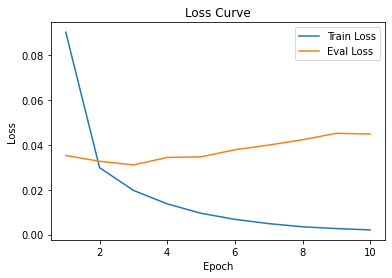

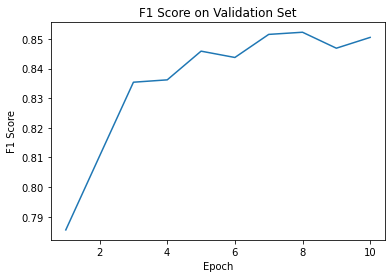

In [27]:
train_losses = []
eval_losses = []
f1_values = []
# acc_values = []
epoch_list = list(range(1, epochs+1))

for entry in trainer_log_history:
  # print(entry)
  if 'loss' in entry:
      train_losses.append(entry['loss'])
  if 'eval_loss' in entry:
      eval_losses.append(entry['eval_loss'])
  if 'eval_f1' in entry:
      f1_values.append(entry['eval_f1'])

# Plot loss curve
plt.plot(epoch_list, train_losses, label='Train Loss')
plt.plot(epoch_list, eval_losses, label='Eval Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Plot F1 score
plt.plot(epoch_list, f1_values, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score on Validation Set')
plt.show()

#### Evaluate on Val set

In [28]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 995
  Batch size = 16


{'eval_loss': 0.04477960616350174,
 'eval_precision': 0.8300954889693777,
 'eval_recall': 0.8720166032514701,
 'eval_f1': 0.8505398110661267,
 'eval_accuracy': 0.9914402521079976,
 'eval_runtime': 15.6613,
 'eval_samples_per_second': 63.532,
 'eval_steps_per_second': 4.023,
 'epoch': 10.0}

#### Evaluate on Test set

In [29]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_encoder.inverse_transform([p])[0] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

true_labels = [
    [label_encoder.inverse_transform([l])[0] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

***** Running Prediction *****
  Num examples = 1074
  Batch size = 16


In [30]:
results = metric.compute(predictions=true_predictions, references=true_labels)

results_dict = {
    "Label": [],
    "Precision": [],
    "Recall": [],
    "F1-score": [],
    "Number": []
}

for label, metrics in results.items():
    if label != "overall_precision" and label != "overall_recall" and label != "overall_f1" and label != "overall_accuracy":
        results_dict["Label"].append(label)
        results_dict["Precision"].append(metrics["precision"])
        results_dict["Recall"].append(metrics["recall"])
        results_dict["F1-score"].append(metrics["f1"])
        results_dict["Number"].append(metrics["number"])

results_df = pd.DataFrame(results_dict)
print(results_df)

print(f"\nOverall Precision :{results['overall_precision']}\nOverall Recall: {results['overall_recall']}\nOverall F1 : {results['overall_f1']}\nOverall Accuracy: {results['overall_accuracy']}\n")


         Label  Precision    Recall  F1-score  Number
0   ASE_NUMBER   0.666667  0.828571  0.738854      70
1          ATE   0.925000  0.965217  0.944681     115
2    ESPONDENT   0.400000  0.285714  0.333333       7
3    ETITIONER   0.458333  0.647059  0.536585      17
4       ITNESS   0.951220  0.951220  0.951220      41
5         OURT   0.876847  0.946809  0.910486     188
6        O_TAG   0.828292  0.868716  0.848023    2049
7           PE   0.548387  0.809524  0.653846      42
8     RECEDENT   0.577778  0.712329  0.638037      73
9     ROVISION   0.850340  0.899281  0.874126     139
10      TATUTE   0.885542  0.948387  0.915888     155
11        UDGE   0.529412  0.947368  0.679245      19

Overall Precision :0.8168158567774936
Overall Recall: 0.8765008576329331
Overall F1 : 0.8456064868442826
Overall Accuracy: 0.9910914370482593



### K FOLD

In [ ]:
# kf = KFold(n_splits=10)

# val_scores = []
# fold = 0
# for train_index, test_index in kf.split(X):
#   hg_data = get_train_test(train_index, test_index)
#   model = get_prepared_model()
#   trainer = get_trainer(hg_data, model)
#   trainer.train()
#   model_path = PATH + "/deberta_kfold/model_{}".format(fold)
#   trainer.save_model(model_path)
#   val_scores.append(val_squish_perfomance(trainer, hg_data))
#   quiz_pred,_,_ = trainer.predict(qhg_dataset)
#   fname = PATH + "/deberta_kfold/fold2_{}".format(fold)
#   np.save(fname, np.array(quiz_pred))
#   fold += 1